# CS391L HW1 - MNIST PCA and kNN

In [178]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
from sklearn.preprocessing import normalize
from keras.datasets import mnist

In [96]:
def hw1FindEigendigits(A):
    '''
    Assume k<x
    Input:  A = (x by k) where x = # of pixels and k = # of examples
    Output: m = (x by 1) mean matrix
            V = (x by k) eigenvectors of covariance matrix
    '''
    # Find mean
    m = np.mean(A,axis=1) # row-wise average (784,)
    m = m[:,np.newaxis]   # (784,1)
    A = A - m             # I_i - I_avg
    
    # Find covariance matrix -- eigenvalues (w), eigenvectors (v) 
    w,v = la.eig( A.T @ A )    # (k,784) * (784,k) = (k,k)
    
    # Sort eigenvectors in descending order to provide ranking of components
    idx = np.argsort(-w) # -w to make it descending
    w = w[idx]
    v = v[:,idx]
    
    # Get top k eigenvectors
    v = A @ v            # (784,k) * (k,k) = (784,k)
    
    # Normalize
    V = normalize(v.real, axis=0)
    
    return m,V

In [240]:
def plot_images(images, col=5, row=1):
    '''
    images = (784,k)
    '''
    k = images.shape[1]
    images = images.T.reshape(k,28,28)
    fig=plt.figure(figsize=(8,8))
    for i,img in enumerate(images):
        fig.add_subplot(row,col,i+1)
        plt.imshow(img)
    plt.show()

## Start

In [142]:
# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Unroll
X_train = X_train.reshape(len(X_train),-1).T
X_test = X_test.reshape(len(X_test),-1).T

print(f'X_train: {X_train.shape}\nX_test:  {X_test.shape}')

X_train: (784, 60000)
X_test:  (784, 10000)


In [235]:
# Consts
n_col = 5
n_rol = 1

SEED = 8

In [179]:
# PCA on 500 random training samples
k = 500
A = X_train[:,:k]
mean, eigendigits = hw1FindEigendigits(A)

print(f'Mean: {mean.shape}\nEigendigits: {eigendigits.shape}')

Mean: (784, 1)
Eigendigits: (784, 500)


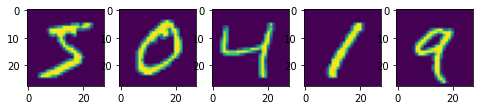

In [159]:
plot_images(A,n_col,n_col)

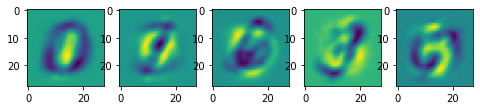

In [160]:
plot_images(eigendigits,n_col,n_col)

## Reconstruct Images

In [243]:
n_samples = 5
n_eigvecs = 100
sample_images = X_test[:,:n_samples] # (784,n_samples)

sample_images = (sample_images - mean).T                 # (n_samples,784)
projection  = sample_images @ eigendigits[:,:n_eigvecs]  # (n_samples,784) * (784,k) = (n_samples,k)
reconstruct = (eigendigits[:,:n_eigvecs] @ projection.T) + mean  # (784,n_samples)

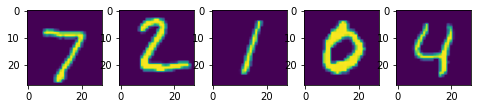

In [244]:
plot_images(X_test[:,:n_samples],n_col,n_col)

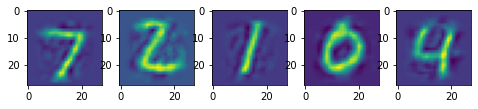

In [245]:
plot_images(reconstruct,n_col,n_col)

## Optimization

In [207]:
import time
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [208]:
# Fine optimal number of training points
n_train_pts = np.array([100, 200, 500, 1000, 2000, 3000, 4000, 5000])
n_train_pts = [x/60000 for x in n_train_pts]

pts_acc = []

for size in n_train_pts:
    # Find mean and eigendigits
    A = X_train[:,:100]
    mean, eigendigits = hw1FindEigendigits(A)
    
    # Project data
    X_train_proj = (X_train - mean).T @ eigendigits
    X_test_proj  = (X_test  - mean).T @ eigendigits

    print(f'X_train_proj: {X_train_proj.shape}\nX_test_proj:  {X_test_proj.shape}')
    
    # Split training and testing dataset
    _, X_train_sample,_, y_train_sample = train_test_split(X_train_proj, y_train, test_size=size, random_state=SEED)
    X_test_sample = X_test_proj[:5000,:]
    y_test_sample = y_test[:5000]

    print(f'X_train_sample: {X_train_sample.shape}\nX_test_sample:  {X_test_sample.shape}')
    
    # kNN
#     start_time = time.time()
    kNN = KNeighborsClassifier(3, weights='distance')
    kNN.fit(X_train_sample,y_train_sample)
    accuracy = kNN.score(X_test_sample, y_test_sample)
    pts_acc.append(accuracy)

    print("acc for training size %s: %s\n\n" %(size*60000, round(accuracy, 4)))
#     print("---- %s seconds" % (round(time.time() - start_time, 4)))

X_train_proj: (60000, 100)
X_test_proj:  (10000, 100)
X_train_sample: (100, 100)
X_test_sample:  (5000, 100)
acc for training size 100.0: 0.6382


X_train_proj: (60000, 100)
X_test_proj:  (10000, 100)
X_train_sample: (200, 100)
X_test_sample:  (5000, 100)
acc for training size 200.0: 0.7114


X_train_proj: (60000, 100)
X_test_proj:  (10000, 100)
X_train_sample: (500, 100)
X_test_sample:  (5000, 100)
acc for training size 500.0: 0.8156


X_train_proj: (60000, 100)
X_test_proj:  (10000, 100)
X_train_sample: (1000, 100)
X_test_sample:  (5000, 100)
acc for training size 1000.0: 0.8632


X_train_proj: (60000, 100)
X_test_proj:  (10000, 100)
X_train_sample: (2000, 100)
X_test_sample:  (5000, 100)
acc for training size 2000.0: 0.8926


X_train_proj: (60000, 100)
X_test_proj:  (10000, 100)
X_train_sample: (3000, 100)
X_test_sample:  (5000, 100)
acc for training size 3000.0: 0.9104


X_train_proj: (60000, 100)
X_test_proj:  (10000, 100)
X_train_sample: (4000, 100)
X_test_sample:  (5000, 100)
ac

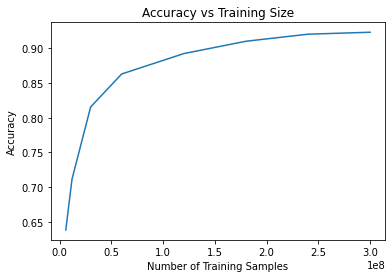

In [214]:
n_train_pts = [x*60000 for x in n_train_pts]
fig, ax = plt.subplots()
ax.plot(n_train_pts, pts_acc)
ax.set_xlabel('Number of Training Samples')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Training Size')
plt.show()

In [222]:
# Find best training size for eigenvectors
n_eig_samples = np.array([10,20,30,40,50,75,100,150,200,500,700])

eig_acc = []

# Find mean and eigendigits
A = X_train[:,:700]
mean, V = hw1FindEigendigits(A)

for n in n_eig_samples:
    eigendigits = V[:,:n]
    
    # Project data
    X_train_proj = (X_train - mean).T @ eigendigits
    X_test_proj  = (X_test  - mean).T @ eigendigits

    print(f'X_train_proj: {X_train_proj.shape}\nX_test_proj:  {X_test_proj.shape}')
    
    # Split training and testing dataset
    _, X_train_sample,_, y_train_sample = train_test_split(X_train_proj, y_train, test_size=0.1, random_state=SEED)
    X_test_sample = X_test_proj[:5000,:]
    y_test_sample = y_test[:5000]

    print(f'X_train_sample: {X_train_sample.shape}\nX_test_sample:  {X_test_sample.shape}')
    
    # kNN
    start_time = time.time()
    kNN = KNeighborsClassifier(3, weights='distance')
    kNN.fit(X_train_sample,y_train_sample)
    accuracy = kNN.score(X_test_sample, y_test_sample)
    eig_acc.append(accuracy)

    print("acc for eig %s: %s" %(n, round(accuracy, 4)))
    print("---- %s seconds\n\n" % (round(time.time() - start_time, 4)))

X_train_proj: (60000, 10)
X_test_proj:  (10000, 10)
X_train_sample: (6000, 10)
X_test_sample:  (5000, 10)
acc for eig 10: 0.8772
---- 0.2825 seconds


X_train_proj: (60000, 20)
X_test_proj:  (10000, 20)
X_train_sample: (6000, 20)
X_test_sample:  (5000, 20)
acc for eig 20: 0.9266
---- 0.7621 seconds


X_train_proj: (60000, 30)
X_test_proj:  (10000, 30)
X_train_sample: (6000, 30)
X_test_sample:  (5000, 30)
acc for eig 30: 0.9352
---- 1.3786 seconds


X_train_proj: (60000, 40)
X_test_proj:  (10000, 40)
X_train_sample: (6000, 40)
X_test_sample:  (5000, 40)
acc for eig 40: 0.9332
---- 1.8732 seconds


X_train_proj: (60000, 50)
X_test_proj:  (10000, 50)
X_train_sample: (6000, 50)
X_test_sample:  (5000, 50)
acc for eig 50: 0.9344
---- 2.7308 seconds


X_train_proj: (60000, 75)
X_test_proj:  (10000, 75)
X_train_sample: (6000, 75)
X_test_sample:  (5000, 75)
acc for eig 75: 0.9304
---- 4.5151 seconds


X_train_proj: (60000, 100)
X_test_proj:  (10000, 100)
X_train_sample: (6000, 100)
X_test_sampl

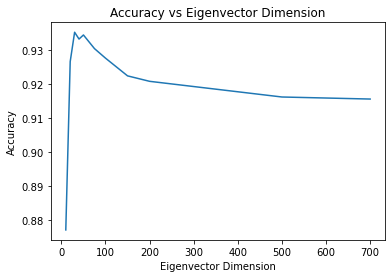

In [223]:
fig, ax = plt.subplots()
ax.plot(n_eig_samples, eig_acc)
ax.set_xlabel('Eigenvector Dimension')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Eigenvector Dimension')
plt.show()

In [248]:
# Find best k value
import operator

A = X_train[:,:700]
mean, eigendigits = hw1FindEigendigits(A)
eigendigits = eigendigits[:,:50]    # Top 50 eigenvectors

# Project data
X_train_proj = (X_train - mean).T @ eigendigits
X_test_proj  = (X_test  - mean).T @ eigendigits

# print(f'X_train_proj: {X_train_proj.shape}\nX_test_proj:  {X_test_proj.shape}')

# Split training and testing dataset
_, X_train_sample,_, y_train_sample = train_test_split(X_train_proj, y_train, test_size=0.1, random_state=SEED)
X_test_sample = X_test_proj[:5000,:]
y_test_sample = y_test[:5000]

# print(f'X_train_sample: {X_train_sample.shape}\nX_test_sample:  {X_test_sample.shape}')

kNN_acc = []
k_vals = []
for k in range(1,20,2):
    kNN = KNeighborsClassifier(k, weights='distance')
    kNN.fit(X_train_sample,y_train_sample)
    accuracy = kNN.score(X_test_sample, y_test_sample)
    kNN_acc.append(accuracy)
    k_vals.append(k)

index, value = max(enumerate(kNN_acc), key=operator.itemgetter(1))
print("Found best k value to be %s with accuracy %s" %(k_vals[index], round(value,4)))

Found best k value to be 3 with accuracy 0.9344


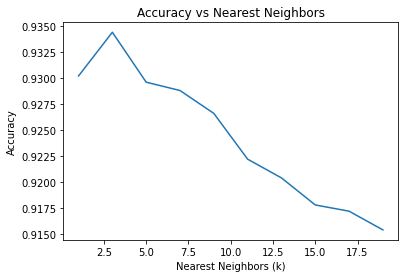

In [247]:
fig, ax = plt.subplots()
ax.plot(k_vals, kNN_acc)
ax.set_xlabel('Nearest Neighbors (k)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Nearest Neighbors')
plt.show()